# RTO Temperature-Demand Polynomial Fits with Data Overlay

This notebook reads the polynomial fits from the JSON files and generates visualizations showing the temperature-demand relationship for each RTO, with actual daily data points overlaid on the polynomial fits.


In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
from pathlib import Path
import warnings
import os
warnings.filterwarnings('ignore')


In [2]:
def find_total_column(df):
    """Find the column name that contains 'total' (case insensitive)."""
    for col in df.columns:
        if 'total' in col.lower():
            return col
    raise ValueError("No column with 'total' in its name found")

def polynomial_function(temp, coefficients, max_degree, weekday_factor=5/7):
    """
    Calculate demand using polynomial coefficients
    
    Parameters:
    -----------
    temp : array-like
        Temperature values in Celsius
    coefficients : dict
        Dictionary containing polynomial coefficients
    max_degree : int
        Maximum polynomial degree
    weekday_factor : float, default=5/7
        Weekday factor (5/7 for average weekday/weekend effect)
    
    Returns:
    --------
    array-like
        Predicted demand values
    """
    demand = coefficients['constant'] + coefficients['temperature'] * temp
    
    # Add polynomial terms
    for degree in range(2, max_degree + 1):
        demand += coefficients[f'temperature^{degree}'] * (temp ** degree)
    
    # Add weekday effect with specified factor
    demand += coefficients['weekday_effect'] * weekday_factor
    
    return demand


In [3]:
def load_polynomial_fits(year, degree):
    """
    Load polynomial fits from JSON file
    
    Parameters:
    -----------
    year : int
        Year of the data (2023 or 2024)
    degree : int
        Polynomial degree (3 or 4)
    
    Returns:
    --------
    dict
        Dictionary containing fit data for all RTOs
    """
    filename = f'polynomial_fits/polynomial_fits_RTO_{year}_degree{degree}.json'
    with open(filename, 'r') as f:
        data = json.load(f)
    return data


In [4]:
def load_rto_data(rto_name, year):
    """
    Load demand and temperature data for a specific RTO and year
    
    Parameters:
    -----------
    rto_name : str
        Name of the RTO (e.g., 'CAISO', 'ERCOT', etc.)
    year : int
        Year of the data
    
    Returns:
    --------
    tuple
        (daily_demand, daily_temp) - pandas Series with daily averages
    """
    # File mapping between RTO names and file prefixes
    rto_file_mapping = {
        'CAISO': 'caiso',
        'ERCOT': 'ercot', 
        'ISONE': 'isone',
        'MISO': 'miso',
        'NYISO': 'nyiso',
        'PJM': 'pjm',
        'SPP': 'spp'
    }
    
    # Temperature file mapping
    temp_file_mapping = {
        'CAISO': 'CALIFORNIA_INDEPENDENT_SYSTEM_OPERATOR_weighted_temp.nc',
        'ERCOT': 'ELECTRIC_RELIABILITY_COUNCIL_OF_TEXAS,_INC._weighted_temp.nc',
        'ISONE': 'ISO_NEW_ENGLAND_INC._weighted_temp.nc',
        'MISO': 'MIDCONTINENT_INDEPENDENT_TRANSMISSION_SYSTEM_OPERATOR,_INC.._weighted_temp.nc',
        'NYISO': 'NEW_YORK_INDEPENDENT_SYSTEM_OPERATOR_weighted_temp.nc',
        'PJM': 'PJM_INTERCONNECTION,_LLC_weighted_temp.nc',
        'SPP': 'SOUTHWEST_POWER_POOL_weighted_temp.nc'
    }
    
    # Load demand data
    demand_file = f'gridstatus_demand/{rto_file_mapping[rto_name]}_load_act_hr_{year}.csv'
    demand_df = pd.read_csv(demand_file, skiprows=3)
    demand_df['datetime'] = pd.to_datetime(demand_df.iloc[:,1])
    demand_df.set_index('datetime', inplace=True)
    
    # Find the total column and convert to GW
    total_column = find_total_column(demand_df)
    region_demand = demand_df[total_column]/1e3
    
    # Calculate daily average demand
    daily_demand = region_demand.resample('D').mean()
    
    # Load temperature data
    temp_file = f'RTO temp calc/weighted_temps/{temp_file_mapping[rto_name]}'
    temp_ds = xr.open_dataset(temp_file)
    temp_series = temp_ds.t2m.to_series()
    
    # Align the dates
    common_dates = daily_demand.index.intersection(temp_series.index)
    daily_demand = daily_demand[common_dates]
    daily_temp = temp_series[common_dates]
    
    # Remove any NaN values
    valid_mask = ~(np.isnan(daily_demand) | np.isnan(daily_temp))
    daily_demand = daily_demand[valid_mask]
    daily_temp = daily_temp[valid_mask]
    
    # Remove zero demand days
    nonzero_mask = (daily_demand > 0)
    daily_demand = daily_demand[nonzero_mask]
    daily_temp = daily_temp[nonzero_mask]
    
    # Apply RTO-specific filters (same as in original script)
    if rto_name == 'PJM':
        pjm_filter = (daily_demand >= 40)
        daily_demand = daily_demand[pjm_filter]
        daily_temp = daily_temp[pjm_filter]
    
    if rto_name == 'ERCOT':
        ercot_filter = (daily_demand <= 80)
        daily_demand = daily_demand[ercot_filter]
        daily_temp = daily_temp[ercot_filter]
    
    return daily_demand, daily_temp


In [10]:
def plot_rto_fits_with_data(year=2024, degree=4, save_plot=False):
    """
    Create a six-panel plot showing temperature-demand fits with actual data overlaid
    
    Parameters:
    -----------
    year : int, default=2024
        Year of the data to plot
    degree : int, default=4
        Polynomial degree to plot
    save_plot : bool, default=False
        Whether to save the plot as a PDF
    """
    # Load the polynomial fits
    data = load_polynomial_fits(year, degree)
    fits = data['fits']
    
    # Create figure with 2x3 subplots
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    # RTO order for consistent plotting (excluding SPP since we only have 6 panels)
    rto_order = ['CAISO', 'ERCOT', 'ISONE', 'MISO', 'NYISO', 'PJM']
    
    # Create a mapping from RTO name to fit data
    rto_fits = {fit['rto']: fit for fit in fits}
    
    for i, rto in enumerate(rto_order):
        if rto not in rto_fits:
            print(f"Warning: No fit data found for {rto}")
            continue
            
        fit = rto_fits[rto]
        ax = axes[i]
        
        try:
            # Load actual data for this RTO and year
            daily_demand, daily_temp = load_rto_data(rto, year)
            
            # Plot actual data points
            ax.scatter(daily_temp.values, daily_demand.values, 
                      alpha=0.6, s=20, color='lightblue', 
                      label='Daily Data', zorder=1)
            
        except Exception as e:
            print(f"Warning: Could not load data for {rto}: {e}")
        
        # Get actual data temperature range (for plotting the fit line)
        data_temp_min = fit['data_range']['min_temp_C']
        data_temp_max = fit['data_range']['max_temp_C']
        
        # Create temperature array for smooth curve - limit to data range
        temp_range = np.linspace(data_temp_min, data_temp_max, 200)
        
        # Get extended range for axis limits
        temp_min = data_temp_min - 5
        temp_max = data_temp_max + 5
        
        # Calculate demand using 5/7 weekday factor (average effect)
        demand_fit = polynomial_function(temp_range, fit['coefficients'], 
                                       fit['fit_details']['max_degree'], 
                                       weekday_factor=5/7)
        
        # Plot the polynomial fit
        ax.plot(temp_range, demand_fit, 'r-', linewidth=3, 
               label='Polynomial Fit', zorder=2)
        
        # Add vertical lines to show actual data range
        ax.axvline(x=data_temp_min, color='gray', 
                  linestyle=':', alpha=0.7, label='Data Range')
        ax.axvline(x=data_temp_max, color='gray', 
                  linestyle=':', alpha=0.7)
        
        # Set axis limits to show extended range
        ax.set_xlim(temp_min, temp_max)
        
        # Formatting
        ax.set_title(f'{rto} ({year})', fontsize=14, fontweight='bold')
        ax.set_xlabel('Daily Average Temperature (°C)', fontsize=12)
        ax.set_ylabel('Daily Average Demand (GW)', fontsize=12)
        ax.grid(True, alpha=0.3)
        
        # Add statistics text box
        stats_text = (f"R² = {fit['fit_statistics']['r2']:.3f}\n"
                     f"RMSE = {fit['fit_statistics']['rmse_GW']:.1f} GW\n"
                     f"Weekday Effect = {fit['coefficients']['weekday_effect']:.1f} GW")
        
        ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, 
               verticalalignment='top', fontsize=10,
               bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8))
        
        # Add legend only to the first subplot
        if i == 0:
            ax.legend(loc='lower right', fontsize=10)
    
    # Add overall title with better positioning
    fig.suptitle(f'Temperature-Demand Relationships for RTOs ({year}) - Degree {degree} Polynomial Fits with Data', 
                fontsize=16, fontweight='bold', y=0.95)
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    
    if save_plot:
        # Create plots directory if it doesn't exist
        Path('plots').mkdir(exist_ok=True)
        filename = f'plots/rto_temperature_demand_fits_with_data_{year}_degree{degree}.pdf'
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        print(f"Plot saved as {filename}")
    
    plt.show()
    
    # Print summary statistics
    print(f"\nSummary for {year} (Degree {degree} Polynomial):")
    print("-" * 60)
    for rto in rto_order:
        if rto in rto_fits:
            fit = rto_fits[rto]
            print(f"{rto:6s}: R² = {fit['fit_statistics']['r2']:.3f}, "
                  f"RMSE = {fit['fit_statistics']['rmse_GW']:5.1f} GW, "
                  f"Weekday Effect = {fit['coefficients']['weekday_effect']:5.1f} GW")


## Generate Plots with Data Overlay for Different Years and Polynomial Degrees


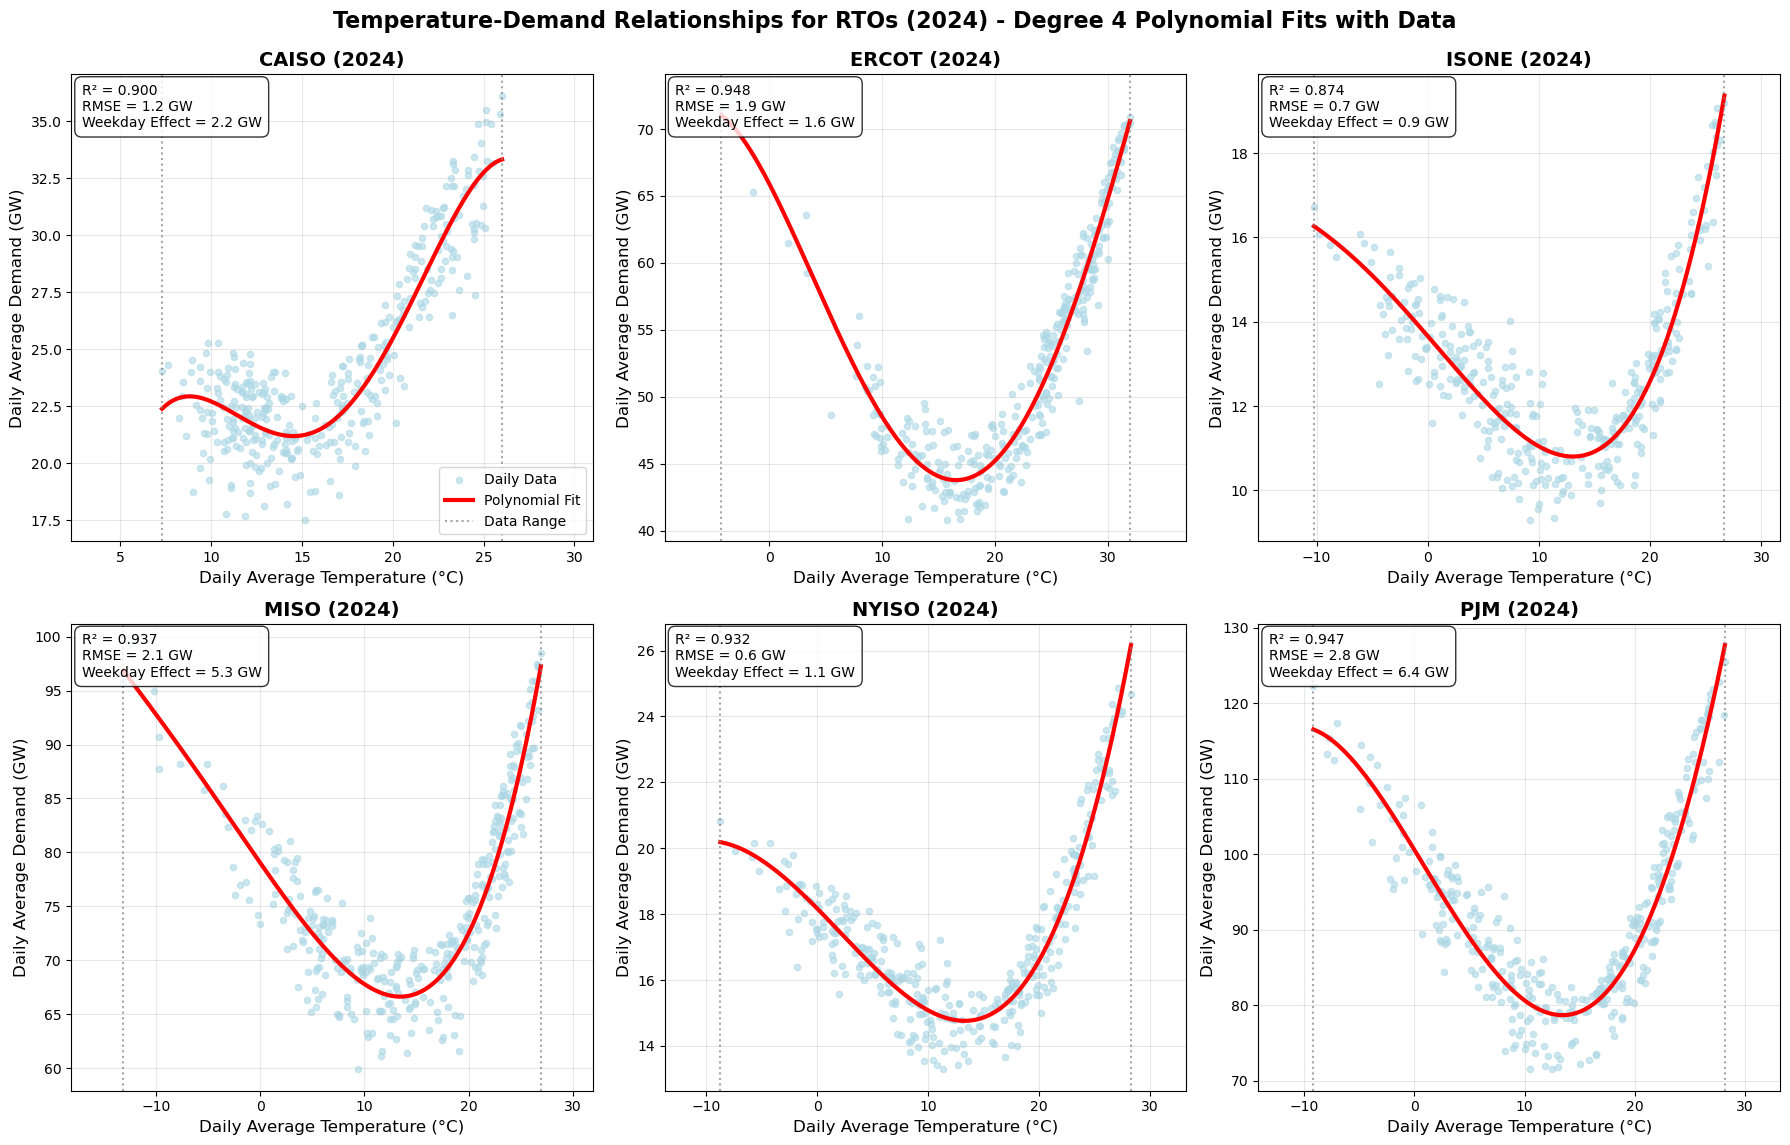


Summary for 2024 (Degree 4 Polynomial):
------------------------------------------------------------
CAISO : R² = 0.900, RMSE =   1.2 GW, Weekday Effect =   2.2 GW
ERCOT : R² = 0.948, RMSE =   1.9 GW, Weekday Effect =   1.6 GW
ISONE : R² = 0.874, RMSE =   0.7 GW, Weekday Effect =   0.9 GW
MISO  : R² = 0.937, RMSE =   2.1 GW, Weekday Effect =   5.3 GW
NYISO : R² = 0.932, RMSE =   0.6 GW, Weekday Effect =   1.1 GW
PJM   : R² = 0.947, RMSE =   2.8 GW, Weekday Effect =   6.4 GW


In [11]:
# Plot 2024 data with degree 4 polynomial and actual data overlay
plot_rto_fits_with_data(year=2024, degree=4)


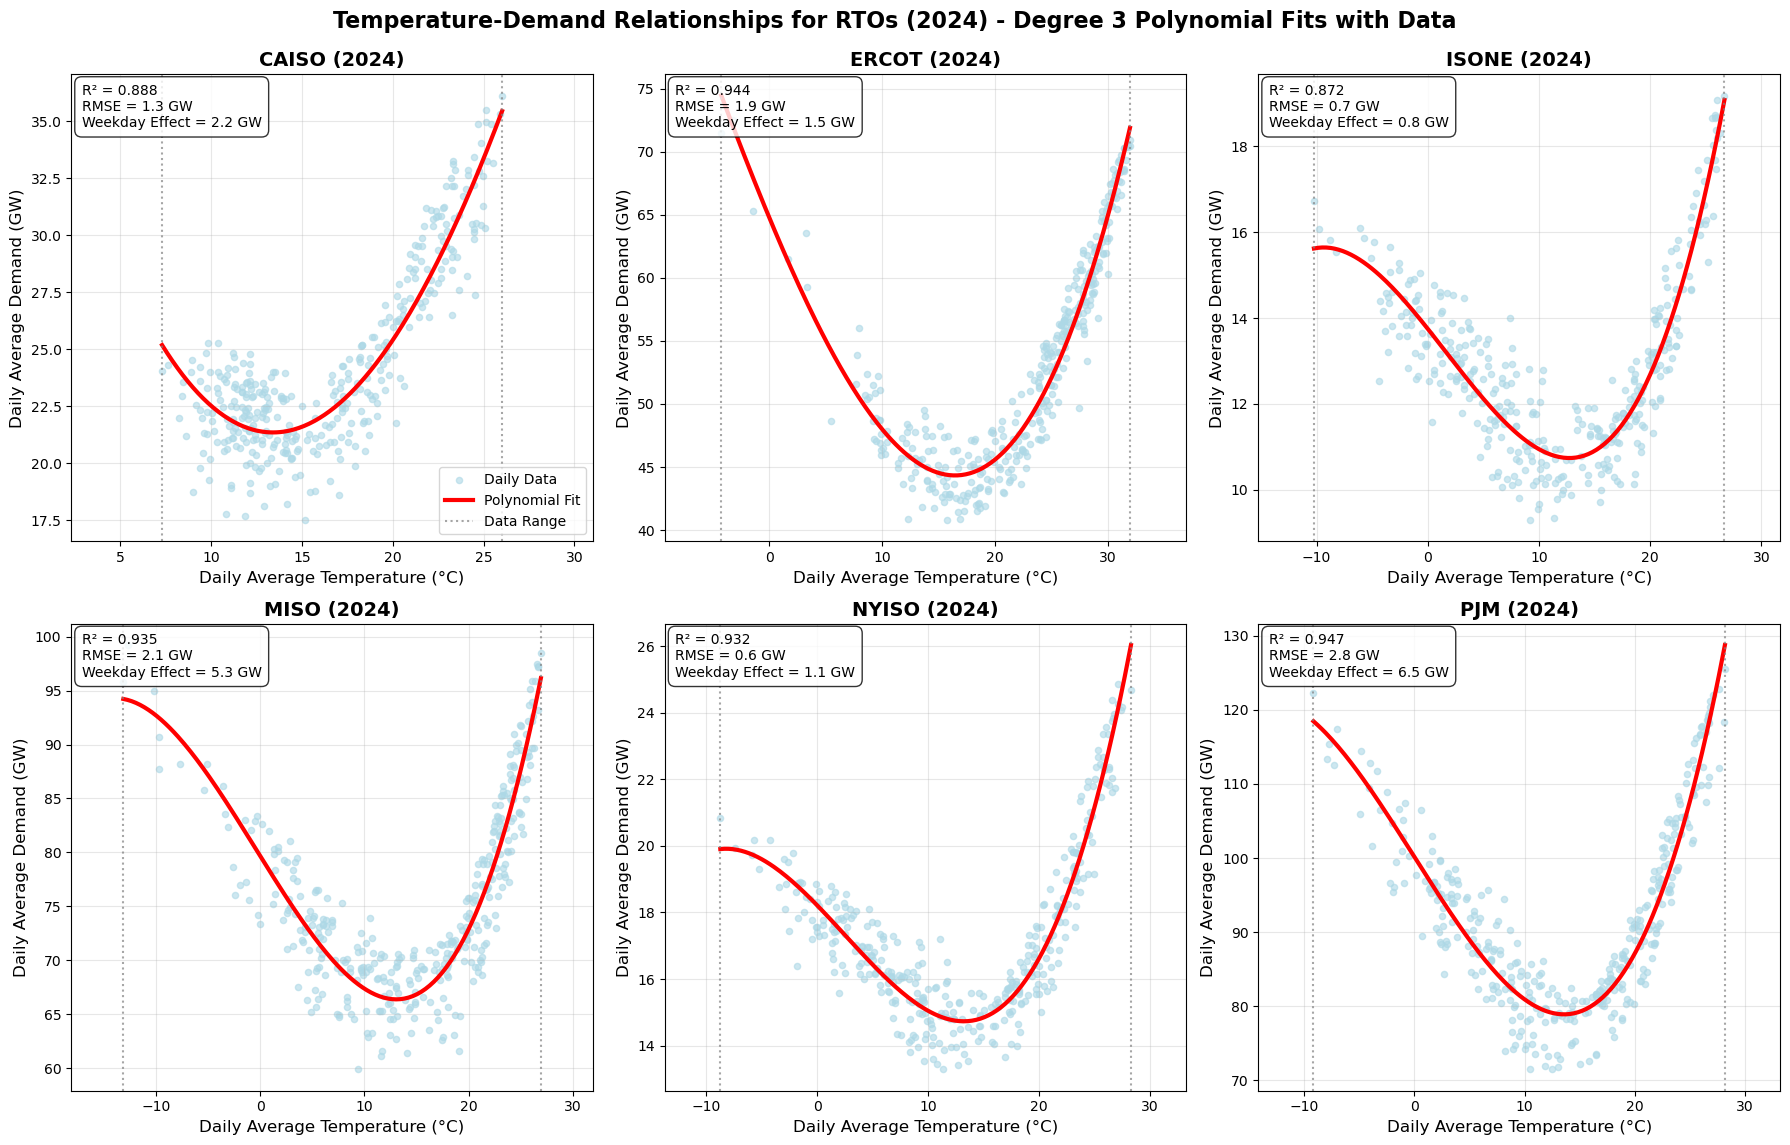


Summary for 2024 (Degree 3 Polynomial):
------------------------------------------------------------
CAISO : R² = 0.888, RMSE =   1.3 GW, Weekday Effect =   2.2 GW
ERCOT : R² = 0.944, RMSE =   1.9 GW, Weekday Effect =   1.5 GW
ISONE : R² = 0.872, RMSE =   0.7 GW, Weekday Effect =   0.8 GW
MISO  : R² = 0.935, RMSE =   2.1 GW, Weekday Effect =   5.3 GW
NYISO : R² = 0.932, RMSE =   0.6 GW, Weekday Effect =   1.1 GW
PJM   : R² = 0.947, RMSE =   2.8 GW, Weekday Effect =   6.5 GW


In [12]:
# Plot 2024 data with degree 3 polynomial and actual data overlay
plot_rto_fits_with_data(year=2024, degree=3)


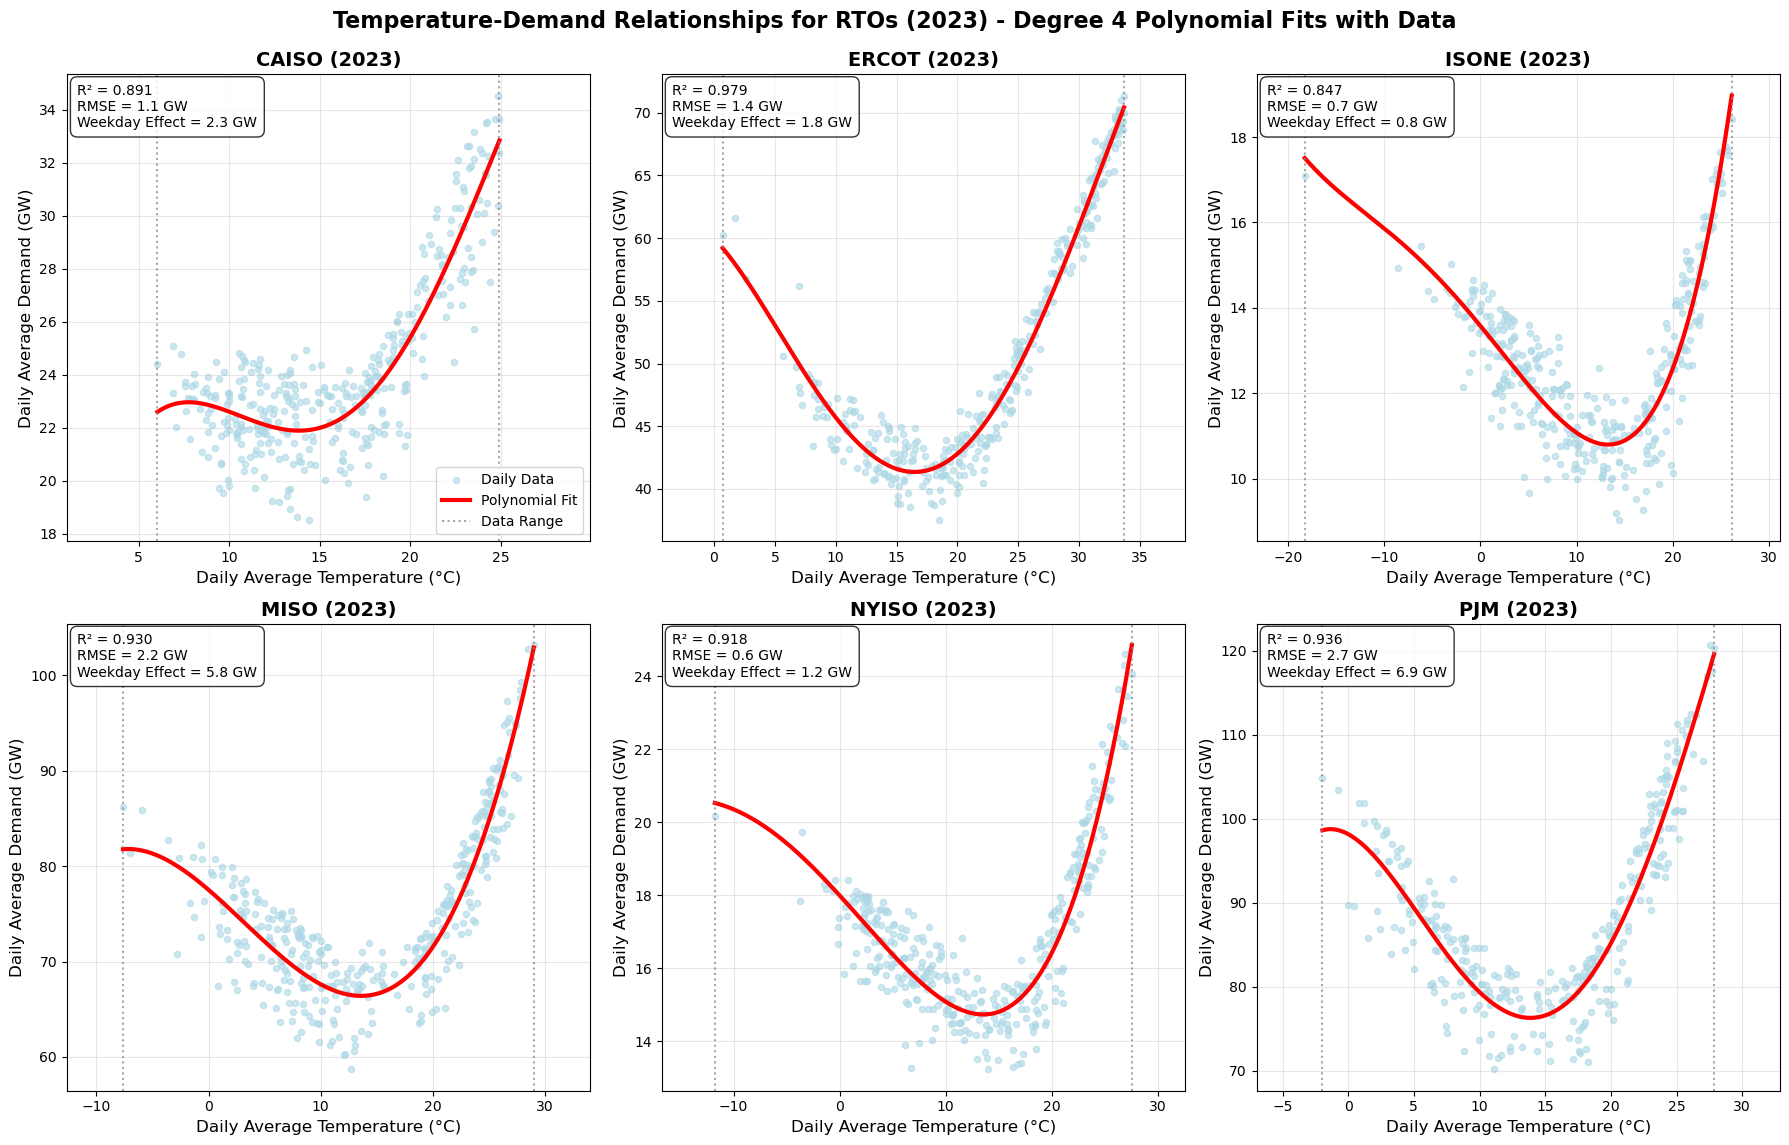


Summary for 2023 (Degree 4 Polynomial):
------------------------------------------------------------
CAISO : R² = 0.891, RMSE =   1.1 GW, Weekday Effect =   2.3 GW
ERCOT : R² = 0.979, RMSE =   1.4 GW, Weekday Effect =   1.8 GW
ISONE : R² = 0.847, RMSE =   0.7 GW, Weekday Effect =   0.8 GW
MISO  : R² = 0.930, RMSE =   2.2 GW, Weekday Effect =   5.8 GW
NYISO : R² = 0.918, RMSE =   0.6 GW, Weekday Effect =   1.2 GW
PJM   : R² = 0.936, RMSE =   2.7 GW, Weekday Effect =   6.9 GW


In [13]:
# Plot 2023 data with degree 4 polynomial and actual data overlay
plot_rto_fits_with_data(year=2023, degree=4)

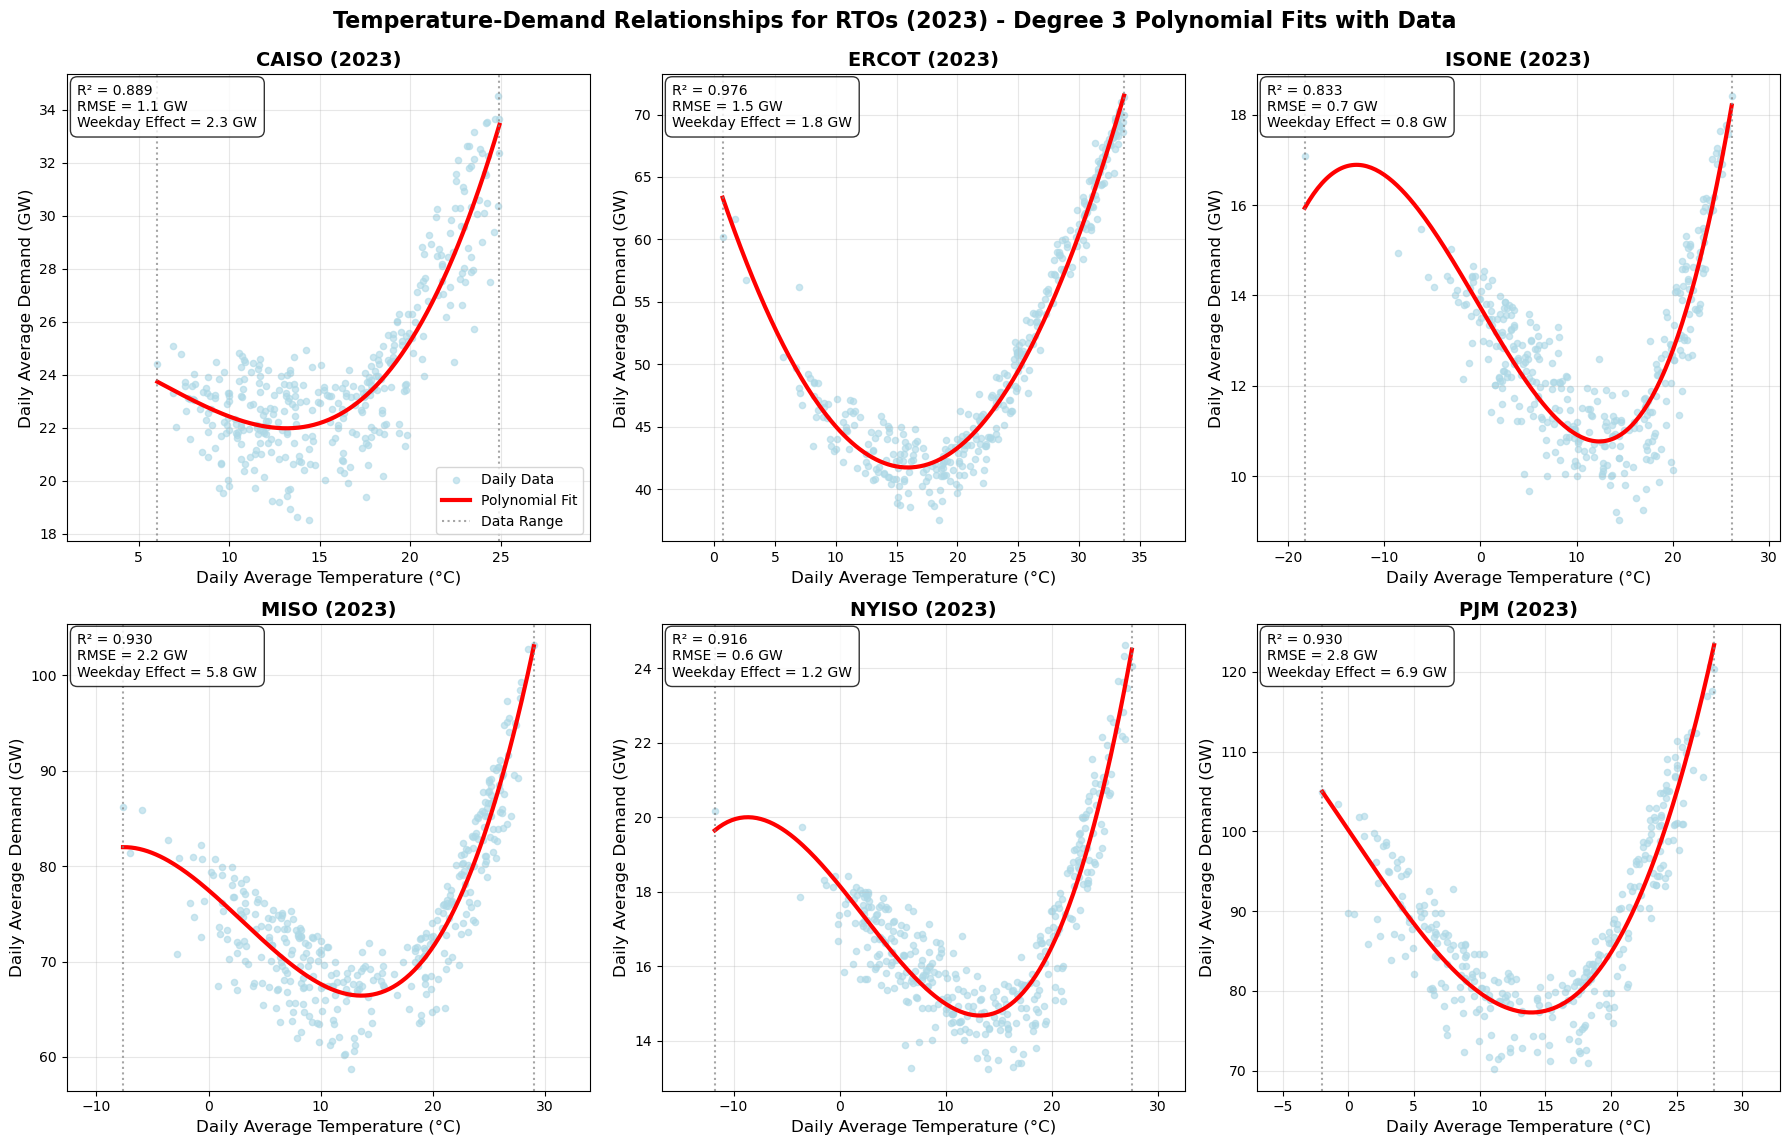


Summary for 2023 (Degree 3 Polynomial):
------------------------------------------------------------
CAISO : R² = 0.889, RMSE =   1.1 GW, Weekday Effect =   2.3 GW
ERCOT : R² = 0.976, RMSE =   1.5 GW, Weekday Effect =   1.8 GW
ISONE : R² = 0.833, RMSE =   0.7 GW, Weekday Effect =   0.8 GW
MISO  : R² = 0.930, RMSE =   2.2 GW, Weekday Effect =   5.8 GW
NYISO : R² = 0.916, RMSE =   0.6 GW, Weekday Effect =   1.2 GW
PJM   : R² = 0.930, RMSE =   2.8 GW, Weekday Effect =   6.9 GW


In [14]:
# Plot 2023 data with degree 3 polynomial and actual data overlay
plot_rto_fits_with_data(year=2023, degree=3)


## Compare Fit Quality Across RTOs and Years


In [ ]:
def compare_fit_quality():
    """
    Create a comparison table of fit quality across different years and polynomial degrees
    """
    results = []
    
    for year in [2023, 2024]:
        for degree in [3, 4]:
            try:
                data = load_polynomial_fits(year, degree)
                for fit in data['fits']:
                    results.append({
                        'Year': year,
                        'Degree': degree,
                        'RTO': fit['rto'],
                        'R²': fit['fit_statistics']['r2'],
                        'RMSE (GW)': fit['fit_statistics']['rmse_GW'],
                        'Weekday Effect (GW)': fit['coefficients']['weekday_effect'],
                        'Avg Demand (GW)': fit['data_range']['avg_demand_GW']
                    })
            except FileNotFoundError:
                print(f"File not found for year {year}, degree {degree}")
    
    df = pd.DataFrame(results)
    
    # Create pivot tables for easier comparison
    print("R² Values by RTO and Configuration:")
    r2_pivot = df.pivot_table(values='R²', index='RTO', 
                             columns=['Year', 'Degree'], aggfunc='mean')
    print(r2_pivot.round(3))
    
    print("\nRMSE Values (GW) by RTO and Configuration:")
    rmse_pivot = df.pivot_table(values='RMSE (GW)', index='RTO', 
                               columns=['Year', 'Degree'], aggfunc='mean')
    print(rmse_pivot.round(1))
    
    return df

comparison_df = compare_fit_quality()


In [ ]:
# Display the full comparison dataframe
print("Complete Comparison Table:")
display(comparison_df.round(3))